# Compare training in SageMaker vs. MLP

## Table of Contents
1. Training Environment 구성 비교
2. Train 실행 비교
3. Model 활용 방안 비교

----

## Training Environment 구성 비교

### ML Platform

ML Platform에서 제공하는 4가지 유형의 학습환경

#### 1. Base Image
- Base image는 어쩌구 저쩌구

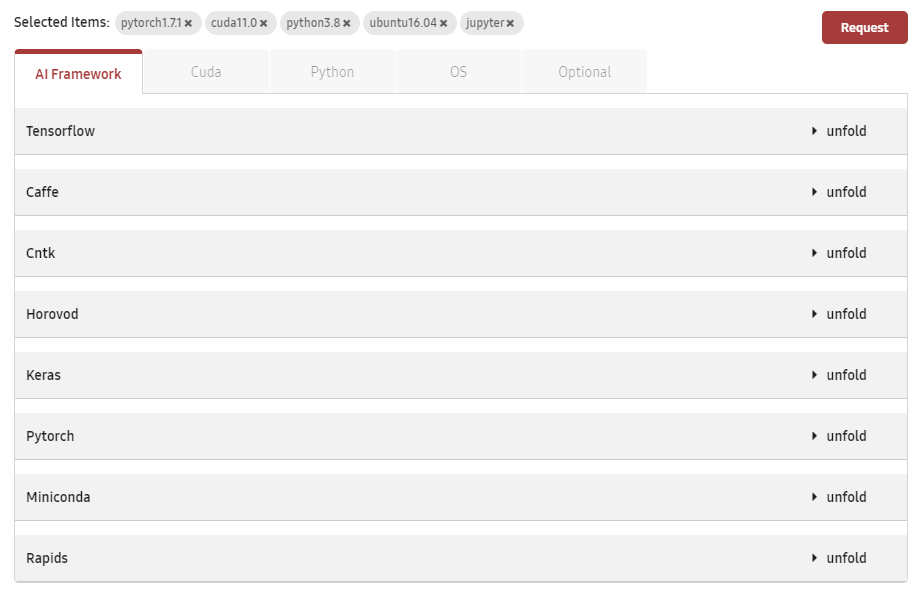

#### 2. Custom Image
- custom image도 어쩌구 저쩌구
- custom image는 share가 가능하다.

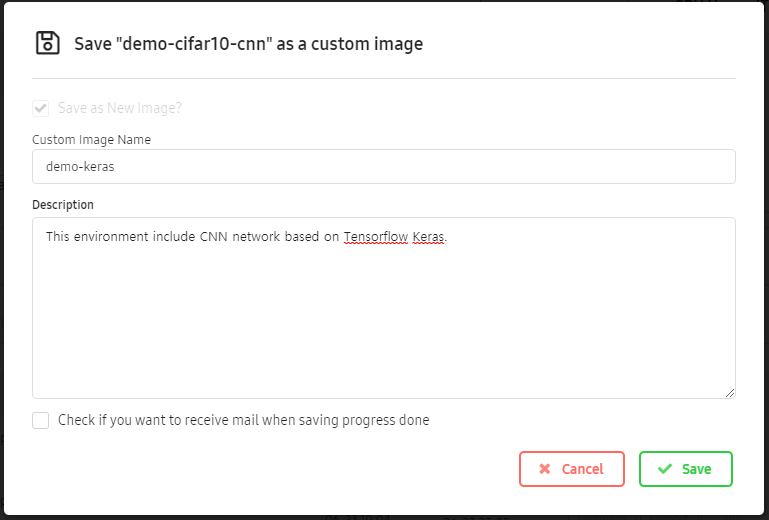

#### 3. Group Image
- Group 이미지는 같은 그룹 멤버끼리 공유할 수 있는 trianing 환경이다

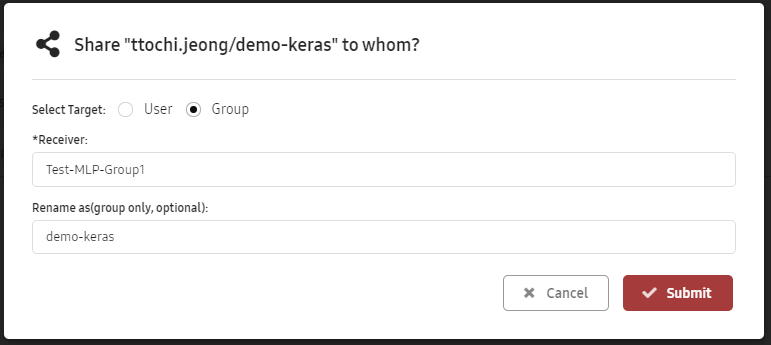

#### 4. Public Image
- MLP에서 자주 사용되는 알고리즘을 이미지로 제공함

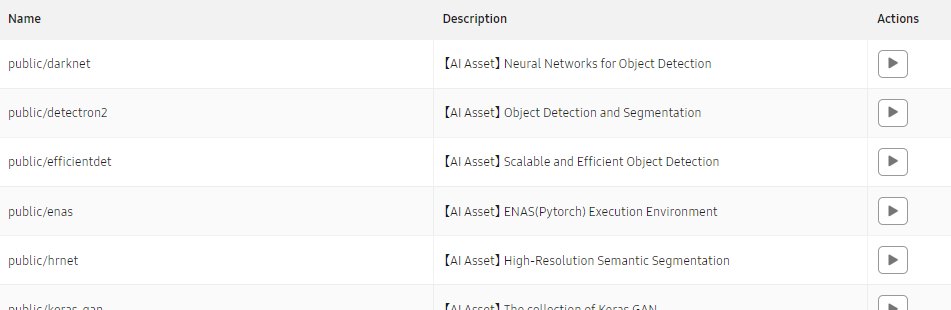

### SageMaker

SageMaker는 4가지 유형의 학습환경을 제공한다.

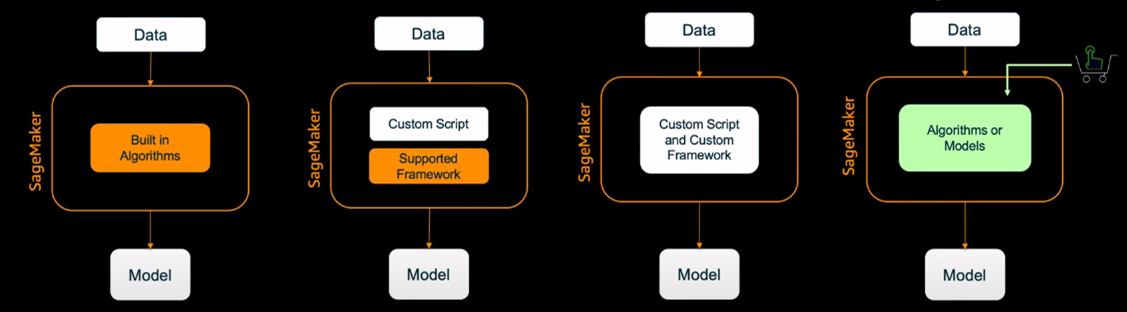

#### 1. Built-in Algorithm

- It is a training algorithm provided by Sagemaker
- No need for the user to configure the model network.
- Train quickly with minimal effort.
- You need to set up an algorithm suitable for your problem type

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("kc_house_data.csv")

# Split train, test, validation data
ys = np.array(df['price']).astype("float32")
xs = np.array(df['sqft_living']).astype("float32").reshape(-1,1)

np.random.seed(8675309)
train_features, test_features, train_labels, test_labels = train_test_split(xs, ys, test_size=0.2)
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)

In [ ]:
import sagemaker

linear_model = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                       base_job_name='builtin',
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       predictor_type='regressor')

train_records = linear_model.record_set(train_features, train_labels, channel='train')
val_records = linear_model.record_set(val_features, val_labels, channel='validation')
test_records = linear_model.record_set(test_features, test_labels, channel='test')

linear_model.fit([train_records, val_records, test_records], logs=False)

#### 2. Script Mode

- Supported frameworks: *Scikit-learn, Spark ML, XGBoost, Tensorflow, Keras, Pytorch, MXNet, Chainer*
- Compatible cuda and cudnn are automatically installed
- Restrictions on installing additional packages (Only PyPi packages are available)
- Users only need to write a script without configure ML framework.

In [ ]:
from sagemaker.pytorch.estimator import PyTorch

pytorch_estimator = PyTorch(
    entry_point='training_script.py',
    framework_version="1.7.1",
    py_version='py3',
    role=sagemaker.get_execution_role(),
    base_job_name='06231855-cifar10-test',
    instance_count=1,
    instance_type=instance_type,
    hyperparameters = {'epochs': 1, 'lr': 0.01, 'batch': 64},
    metric_definitions=[
        {'Name': 'accuracy', 'Regex': 'Test Accuracy: (\S+)'}
    ]
)

input_s3 = 's3://sagemaker-ap-northeast-2-834160605896/data/cifar10'

pytorch_estimator.fit(input_s3, logs=False)

#### 3. Custom Image

- User can configure training env and build the container image and save in registry
- Must build according to the guide so that sagemaker can run
- With image registry uri, users can share it with others

In [ ]:
from sagemaker.estimator import Estimator

custom_image_uri = '834160605896.dkr.ecr.ap-northeast-2.amazonaws.com/mlp/mlp-base-image:pytorch-2'

estimator = Estimator(
    image_uri=custom_image_uri,
    role=sagemaker.get_execution_role(),
    base_job_name='customimage',
    instance_count=1,
    instance_type='ml.p2.xlarge'
)

# start training
estimator.fit()

#### 4. AWS Marketplace algorithm

- Various external vendors are selling SageMaker Algorithm through AWS Market.

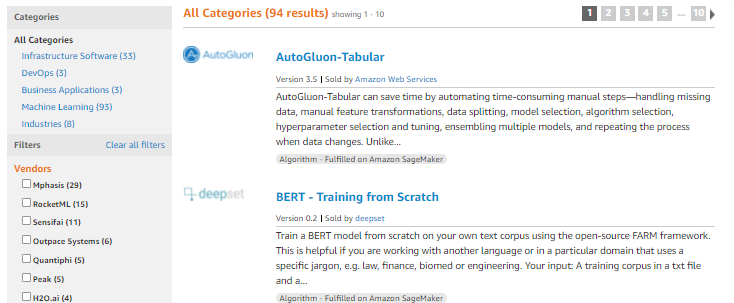

In [ ]:
from sagemaker.algorithm import AlgorithmEstimator

algorithm_arn = "arn:aws:sagemaker:ap-northeast-2:745090734665:algorithm/autogluon-tabular-v3-5-cb7001bd0e8243b50adc3338deb44a48"

algo = AlgorithmEstimator(
    algorithm_arn=algorithm_arn,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    base_job_name="autogluon",
    hyperparameters={"init_args": init_args, "fit_args": fit_args, "feature_importance": True},
    train_volume_size=100,
)

inputs = {"training": train_s3_path}

algo.fit(inputs)

---

## Train 실행 비교

### ML Platform

### SageMaker

---

## Model 활용 방안 비교

### ML Platform

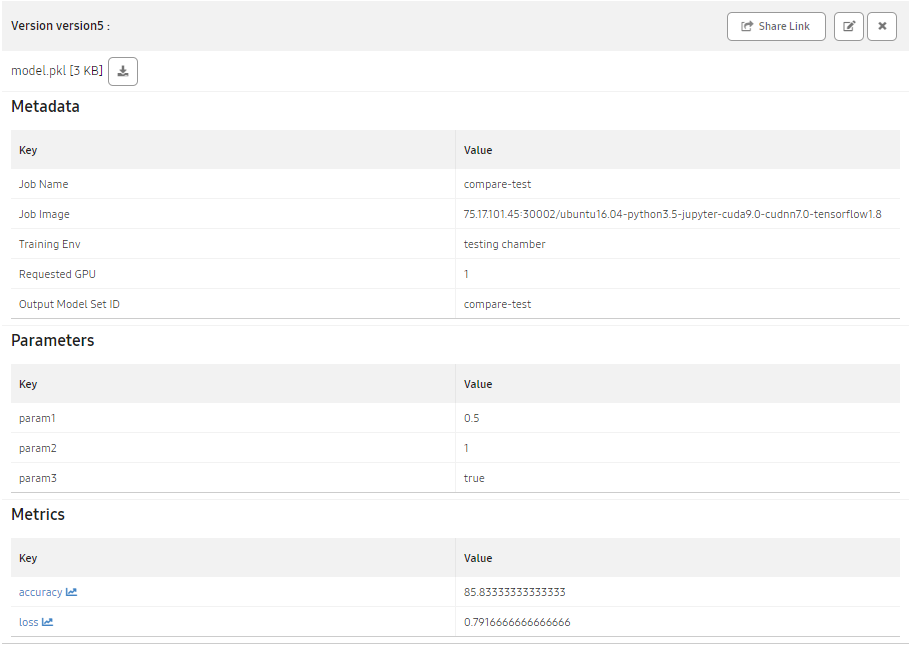

### SageMaker

After a training, we can host the newly created model in SageMaker.

To create a SageMaker inference endpoint, we can call deploy method on a PyTorch Estimator.
The deployed server runs a and hosts the .

After create inference endpoint, we can check the API url.

In [ ]:
cifar10_predictor = pytorch_estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

In [ ]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

----

## Summary

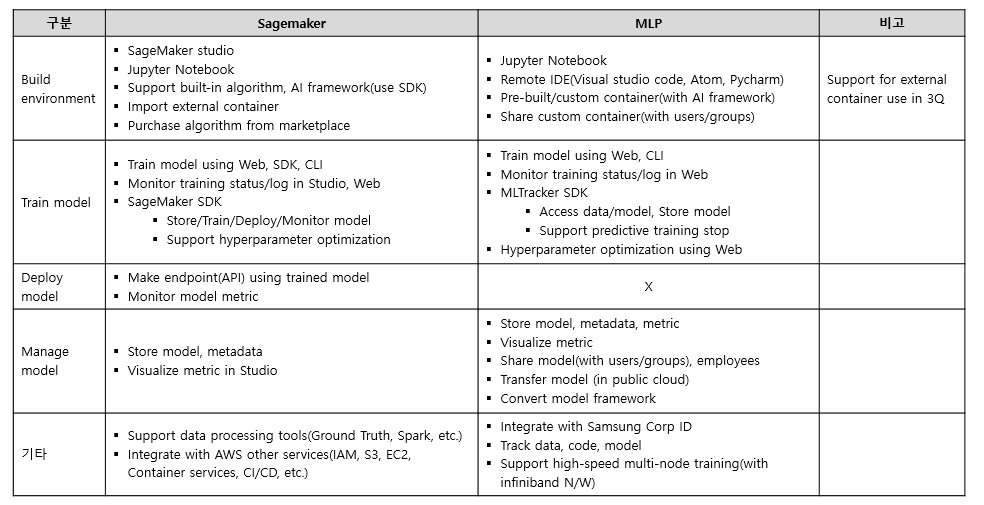